In [108]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from pathlib import Path

In [109]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [110]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [111]:
# create engine to hawaii.sqlite
database_path = Path("Resources/hawaii.sqlite")
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

In [112]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [113]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [114]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [115]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [116]:
# Find the most recent date in the data set.
# https://sparkbyexamples.com/python/convert-tuple-to-string-in-python/
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = "".join(latest_date)

latest_date

'2017-08-23'

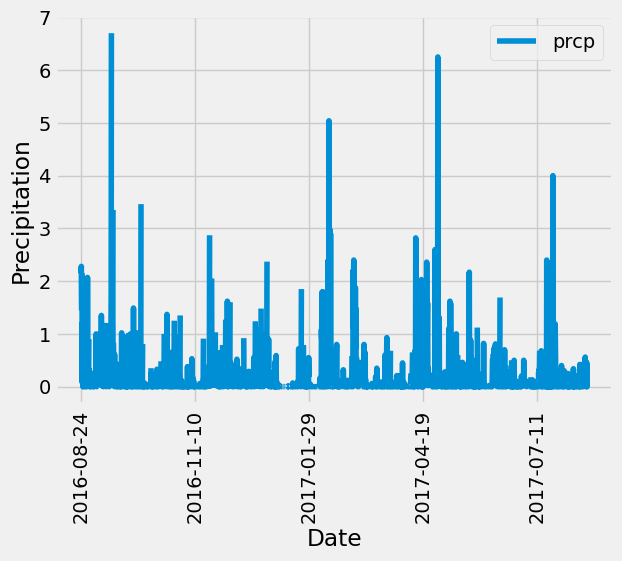

In [132]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# https://www.digitalocean.com/community/tutorials/python-string-to-datetime-strptime
#Worked with cgallant from Ask BCS
#Worked with Luna Zhang from Ask BCS - plotting problems

last_day = dt.datetime.strptime(latest_date, "%Y-%m-%d").date()

# Calculate the date one year from the last date in data set.
one_year = last_day - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
result = session.query(Measurement).filter(Measurement.date >= one_year)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Directions in the instructions are not clear. We were told that any way we can do this is fine
sql_statement = f'''
Select id AS id, station as station, date as date, prcp as prcp, tobs as tobs
From Measurement
Where date > "{one_year}"
'''
#df_measurement = pd.read_sql('SELECT * FROM Measurement', conn)
df_measurement = pd.read_sql(sql_statement, conn)

# Sort the dataframe by date
df_measurement = df_measurement.sort_values(by=['date','station'])

df_measurement.plot(x='date', y='prcp', rot=90)

plt.xlabel('Date')
plt.ylabel('Precipitation')

plt.show()

In [118]:
# Use Pandas to calculate the summary statistics for the precipitation data
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

df_measurement.prcp.describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [119]:
# Design a query to calculate the total number of stations in the dataset
sql_statement = f'''
Select COUNT(*)
From Station
'''

num_of_stations = pd.read_sql(sql_statement, conn)
num_of_stations

,COUNT(*)
0,9


In [120]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sql_statement = f'''
Select station, COUNT(station) as count
From Measurement
Group By station
Order By count desc
'''
stations = pd.read_sql(sql_statement, conn)
stations

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [121]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = stations.iloc[0,0]

sql_statement = f'''
Select MIN(tobs) as min_temp, MAX(tobs) as max_temp, AVG(tobs) as avg_temp
From Measurement
Where station = "{most_active}"
'''

central_measurement = pd.read_sql(sql_statement, conn)
central_measurement

,min_temp,max_temp,avg_temp
0,54.0,85.0,71.663781


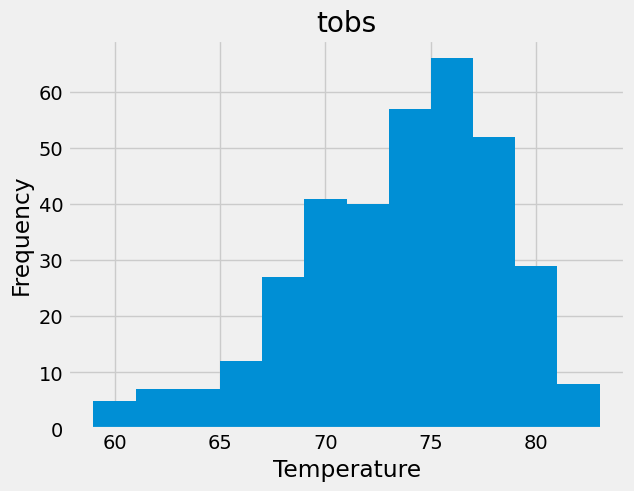

In [128]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# https://mode.com/example-gallery/python_histogram/
sql_statement = f'''
Select tobs
From Measurement
Where station = "{most_active}"
And date > "{one_year}"
'''
top_station = pd.read_sql(sql_statement, conn)

top_station.hist(column='tobs', bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [123]:
# Close Session
session.close()